In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14

from sklearn import linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, f1_score, brier_score_loss

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
def gen_auc_viz(fpr, tpr, threshold):
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.title('Reorder (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();

In [3]:
def plot_cm(classifier,
             X_var,
             y_var,
             pred_var,
             cmap=plt.cm.Blues,
             title='Confusion matrix'):
    
    plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues)  
    plt.show() 
    
    cm = pd.DataFrame(metrics.confusion_matrix(y_true=y_var, y_pred=pred_var))
    
    tn = cm.iloc[0,0]
    fn = cm.iloc[1,0]
    fp = cm.iloc[0,1]
    tp = cm.iloc[1,1]
    
    acc = (tp+tn) / (tp+tn+fp+fn)
    sen = (tp) / (tp+fn) #summarizes how well the positive class was predicted.
    prec = tp / (tp+fp) #summarizes the fraction of examples assigned the positive class that belong to the positive class
    rec = tp/(tp+fn) #same as sensitivity 
    pp = tp / (tp+fp)
    
    return acc, sen, prec, rec, pp

In [4]:
def scores_output(y_test, y_pred):

    f1=f1_score(y_test,y_pred)
    brier=brier_score_loss(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    
    print(classification_report(y_test,y_pred))
    print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

In [5]:
full_df = pd.read_csv('../../data/full_df.csv')
# train_df = pd.read_csv('../../data/train_df.csv')
# prior_df = pd.read_csv('../../data/prior_df.csv')
# test_df = pd.read_csv('../../data/test_df.csv')

In [6]:
full_df.drop('Unnamed: 0',axis=1,inplace=True)
full_df.head()

,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,...,user_reorder_ratio,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
0,112108,49302,train,1,1,3,1,4,2.000,170,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
1,112108,11109,train,1,1,3,1,4,3.333,4579,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
2,112108,43633,train,1,1,3,1,4,4.000,663,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
3,112108,22035,train,1,1,3,1,4,6.000,61241,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
4,79431,19660,train,1,36,16,2,23,4.562,57921,...,0.500,23,3238.000,17.598,30.000,2.000,8.391,0.696,0.727,0


In [7]:
#filling in null values - for previous calculations where user didn't do any reorders
full_df.product_ordered_twice_vol.fillna(0,inplace=True)
full_df.product_order_twice_ratio.fillna(0,inplace=True)
full_df.user_unique_reorder_count.fillna(0,inplace=True)
full_df.user_unique_reorder_perc.fillna(0,inplace=True)
full_df.user_total_items_after_first_order.fillna(0,inplace=True)
full_df.user_reorder_ratio.fillna(0,inplace=True)
full_df.isnull().sum()

user_id                                   0
product_id                                0
eval_set                                  0
target                                    0
order_id                                  0
user_product_count                        0
user_product_first_order                  0
user_product_last_order                   0
user_product_avg_basket_placement         0
product_ordered_vol                       0
product_reordered_vol                     0
product_ordered_once_vol                  0
product_ordered_twice_vol                 0
product_order_twice_ratio                 0
product_avg_reorders                      0
product_overall_reorder_prob              0
user_total_products                       0
user_total_products_reordered             0
user_unique_product_count                 0
user_unique_reorder_count                 0
user_unique_product_perc                  0
user_unique_reorder_perc                  0
user_total_items_after_first_ord

In [8]:
print(full_df.target.value_counts())
print(full_df.target.value_counts(normalize=True))


0    7645837
1     828824
Name: target, dtype: int64
0   0.902
1   0.098
Name: target, dtype: float64


<AxesSubplot:>

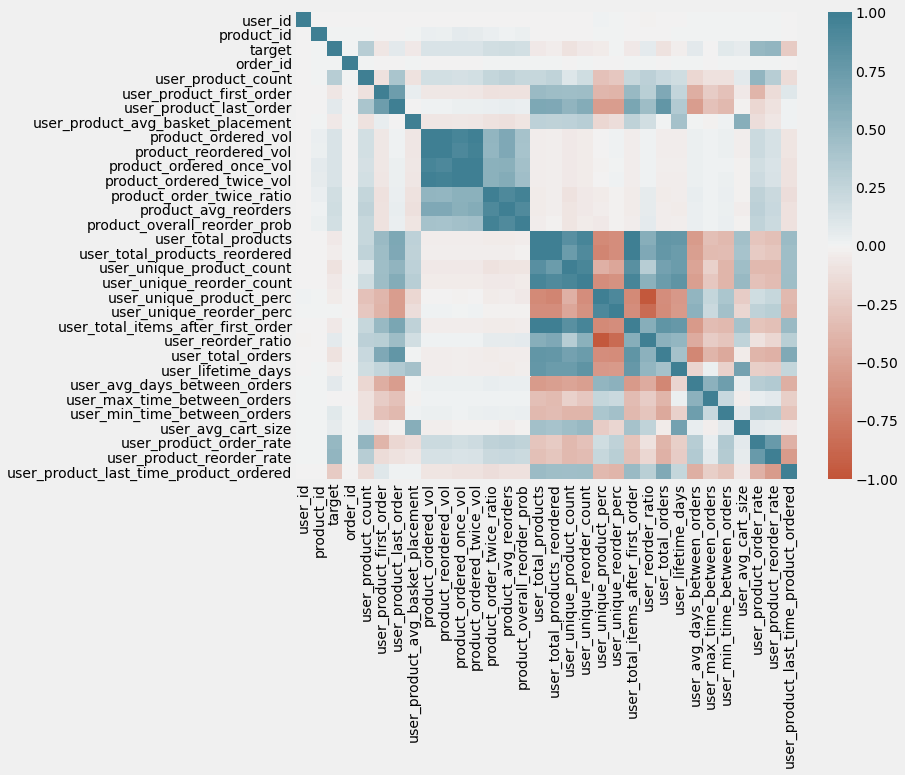

In [9]:
sns.heatmap(full_df.corr(),vmin=-1, vmax=1, center=0,
           cmap=sns.diverging_palette(20, 220, n=200))

In [10]:
full_df.drop(['product_ordered_once_vol','product_reordered_vol',
             'user_unique_product_count','user_unique_reorder_count',
             'user_total_items_after_first_order'],axis=1, inplace=True)

<AxesSubplot:>

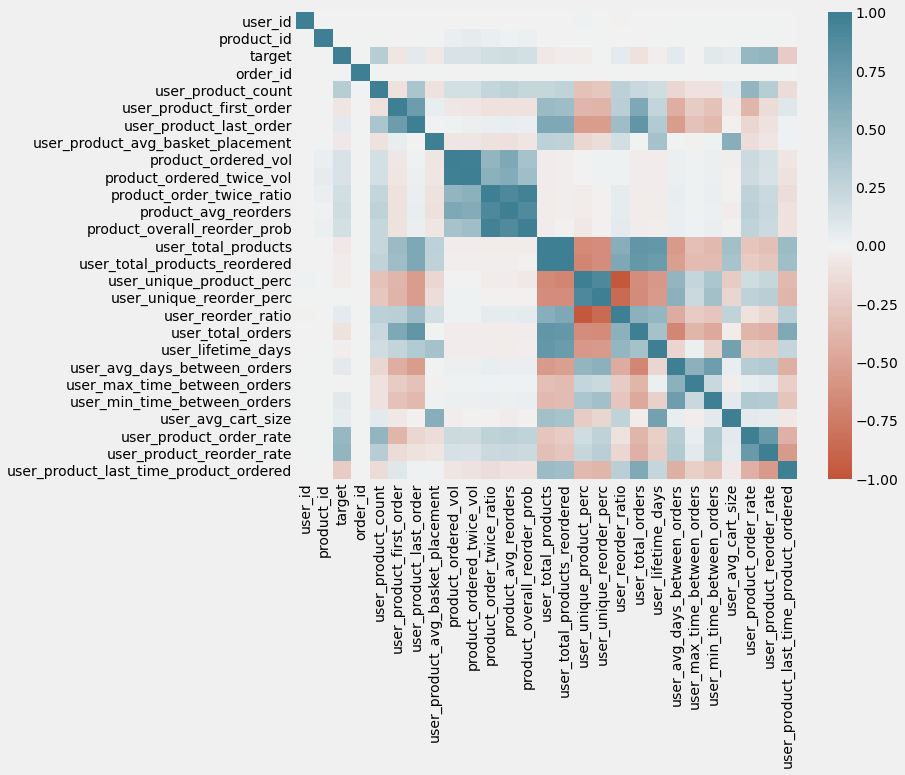

In [11]:
sns.heatmap(full_df.corr(),vmin=-1, vmax=1, center=0,
           cmap=sns.diverging_palette(20, 220, n=200))

### Multicolinearity Check 
columns that have high correlation with other features

In [12]:
cor_matrix = full_df.corr().abs()
upper = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# print(upper)

drop_these = [column for column in upper.columns if any(upper[column] > 0.80)]

In [13]:
drop_these

['product_ordered_twice_vol',
 'product_avg_reorders',
 'product_overall_reorder_prob',
 'user_total_products_reordered',
 'user_unique_reorder_perc',
 'user_reorder_ratio']

In [14]:
full_new = full_df.drop(full_df[drop_these], axis=1)
full_new.head()

,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,...,user_unique_product_perc,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
0,112108,49302,train,1,1,3,1,4,2.000,170,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
1,112108,11109,train,1,1,3,1,4,3.333,4579,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
2,112108,43633,train,1,1,3,1,4,4.000,663,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
3,112108,22035,train,1,1,3,1,4,6.000,61241,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
4,79431,19660,train,1,36,16,2,23,4.562,57921,...,0.523,23,3238.000,17.598,30.000,2.000,8.391,0.696,0.727,0


## Splitting Data
Will first split dataset into train, test, validation sets and then do a T/T/S on training set for model tuning

In [15]:
full_df.shape

(8474661, 28)

In [16]:
full_new.shape

(8474661, 22)

In [17]:
np.random.seed(42)
train, validate, test = \
        np.split(full_new.sample(frac=1, random_state=42), 
                 [int(.6*len(full_new)), int(.8*len(full_new))])
#                  [int(.8*len(full_new))])                 

In [18]:
print(train.shape) #60%
print(test.shape) #20%
print(validate.shape) #20

(5084796, 22)
(1694933, 22)
(1694932, 22)


In [19]:
print(train.target.mean())
print(test.target.mean())
print(validate.target.mean())
print(test.target.mean())

0.09785564651954572
0.09759146821732777
0.09784286331251048
0.09759146821732777


In [20]:
X= train.drop(["target",'eval_set'],axis=1)
y= train['target']

In [67]:
print(X.mean())
print(X.std())

train_mean = X.mean()
train_std = X.std()

user_id                                   103015.174
product_id                                 25508.620
order_id                                 1704448.744
user_product_count                             2.533
user_product_first_order                      10.694
user_product_last_order                       16.197
user_product_avg_basket_placement              9.195
product_ordered_vol                        23227.959
product_order_twice_ratio                      0.836
user_total_products                          318.853
user_unique_product_perc                       0.474
user_total_orders                             26.357
user_lifetime_days                          2908.623
user_avg_days_between_orders                  13.064
user_max_time_between_orders                  26.547
user_min_time_between_orders                   3.793
user_avg_cart_size                            12.318
user_product_order_rate                        0.147
user_product_reorder_rate                     

In [21]:
X_val = validate.drop(["target",'eval_set'],axis=1)

In [22]:
X_fin = test.drop(["target",'eval_set'],axis=1)

In [23]:
print(X.shape)
print(y.shape)

(5084796, 20)
(5084796,)


In [24]:
#comparing feature means for train test validation data 
pd.concat([X.mean(),X_val.mean(),X_fin.mean()], axis=1)

,0,1,2
user_id,103015.174,102926.503,102928.164
product_id,25508.620,25507.499,25525.199
order_id,1704448.744,1703358.945,1702091.866
user_product_count,2.533,2.535,2.533
user_product_first_order,10.694,10.695,10.694
user_product_last_order,16.197,16.191,16.185
user_product_avg_basket_placement,9.195,9.198,9.195
product_ordered_vol,23227.959,23173.308,23095.723
product_order_twice_ratio,0.836,0.836,0.836
user_total_products,318.853,318.987,318.509


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
type(X_train)

(4067836, 20)
(1016960, 20)
(4067836,)
(1016960,)


pandas.core.frame.DataFrame

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# print(y_test.shape)
# print(X_test.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)

(4067836, 20)
(1016960, 20)
(4067836,)


In [29]:
zip(set(y_train), ('orange', 'blue'))

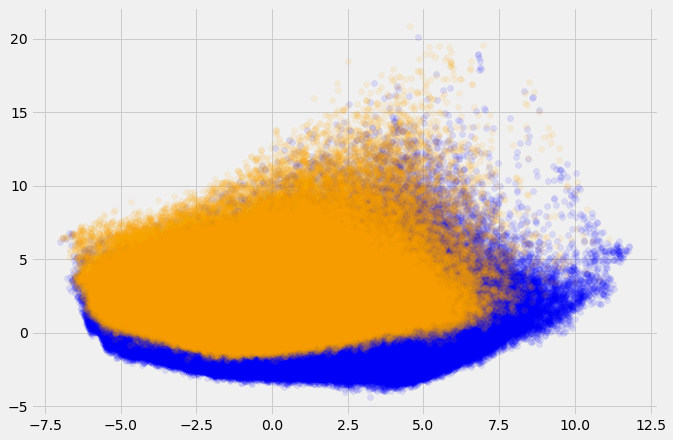

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_dim_red = pca.fit_transform(X_train_scaled)
X_test_dim_red = pca.transform(X_test_scaled)

fig, ax = plt.subplots(figsize=(10, 7))
for label, color in zip(set(y_train), ('blue', 'orange')):
    ax.scatter(
        X_train_dim_red[y_train == label, 0],
        X_train_dim_red[y_train == label, 1],
        color=color, label=f'Class {label}',
        alpha=0.1)

In [31]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
X_train

array([[ 0.03956461,  1.62327965,  1.4064979 , ..., -0.47614291,
        -0.54977413, -0.23377069],
       [ 0.34691101, -0.04595348,  1.57251043, ...,  0.64752773,
         0.40652981, -0.60332339],
       [-0.34436614, -1.51200741, -0.66553403, ...,  2.54171538,
         3.00767651, -0.75114446],
       ...,
       [-1.69231118,  0.14091514, -1.17253096, ..., -0.65202179,
        -0.89404354,  0.65315578],
       [-1.63402367, -0.37905488,  0.98016741, ..., -0.7289688 ,
        -0.54977413, -0.23377069],
       [-0.40083743,  0.04944935,  0.59220755, ...,  1.8710802 ,
         1.17157296, -0.75114446]])

## Logistic Regression 

In [32]:
1-y_train.mean()

0.9021991053719963

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(logreg.score(X_test, y_test))


0.9964600377595972


In [35]:
reorder_logit_prob = logreg.predict_proba(X_test)[:,1]

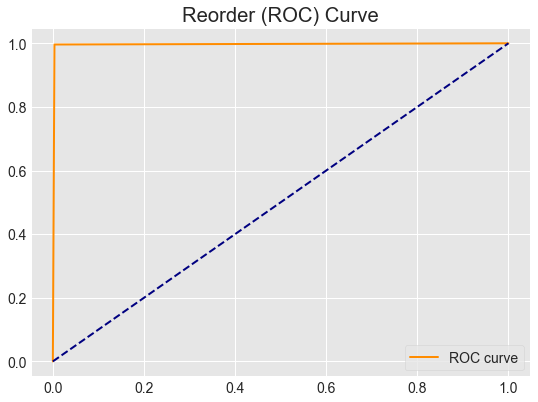

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gen_auc_viz(fpr, tpr, thresholds)

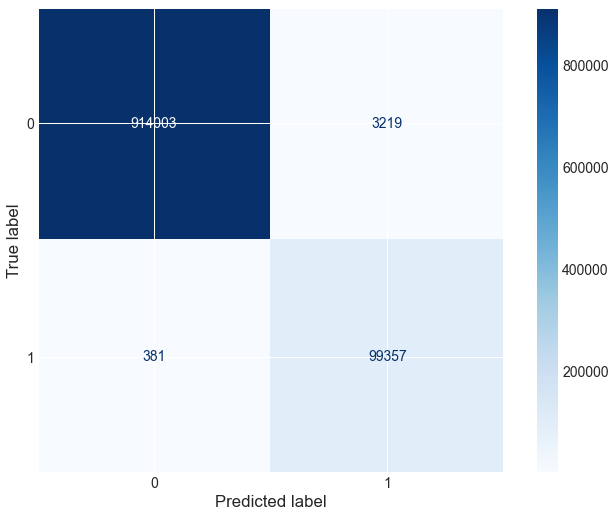

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    917222
           1       0.97      1.00      0.98     99738

    accuracy                           1.00   1016960
   macro avg       0.98      1.00      0.99   1016960
weighted avg       1.00      1.00      1.00   1016960

f1:0.98221,auc:0.99634,loss_score:0.00354


In [37]:
plot_cm(logreg, X_test, y_test, y_pred)

f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

Doesn't accuractely predict true positive class

### Tuning Regularization Parameter C

In [38]:
# C_param_range = [0.001,0.01,0.1,1,10,100,1000]

# stored_score_vals = pd.DataFrame(columns = ['C_parameter','F1','AUC','Accuracy'])
# stored_score_vals['C_parameter'] = C_param_range

# j = 0
# for i in C_param_range:
#     logreg = LogisticRegression(penalty = 'l2', C= i, random_state = 0)
#     logreg.fit(X_train, y_train)
    
#     y_pred = logreg.predict(X_test)
#     print(logreg.score(X_test, y_test))
    
#     reorder_logit_prob = logreg.predict_proba(X_test)[:,1]
    
#     stored_score_vals.iloc[j,1] = f1_score(y_test,y_pred)
#     stored_score_vals.iloc[j,2] = roc_auc_score(y_test,y_pred)
#     stored_score_vals.iloc[j,3] = accuracy_score(y_test,y_pred)
#     j += 1



In [39]:
from sklearn.model_selection import GridSearchCV

# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
# clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
# GridSearchCV(cv=None,
#              estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
#                dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
#              param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

clf = LogisticRegression(max_iter=500)
grid_values = {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25,100,1000]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'f1')

grid_clf_acc.fit(X_train, y_train)

y_pred = grid_clf_acc.predict(X_test)

f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    917222
           1       0.97      1.00      0.98     99738

    accuracy                           1.00   1016960
   macro avg       0.98      1.00      0.99   1016960
weighted avg       1.00      1.00      1.00   1016960

f1:0.98246,auc:0.99591,loss_score:0.00349


array([[914159,   3063],
       [   482,  99256]])

In [40]:
grid_clf_acc.best_params_

{'C': 1000, 'penalty': 'l2'}

In [41]:
# stored_score_vals

In [64]:
logreg = LogisticRegression(penalty = 'l2', C= 0.01, random_state = 0, max_iter=500)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
reorder_logit_prob = logreg.predict_proba(X_test)[:,1]

In [46]:
# X_test.head()
print(X_test.shape)

(1016960, 20)


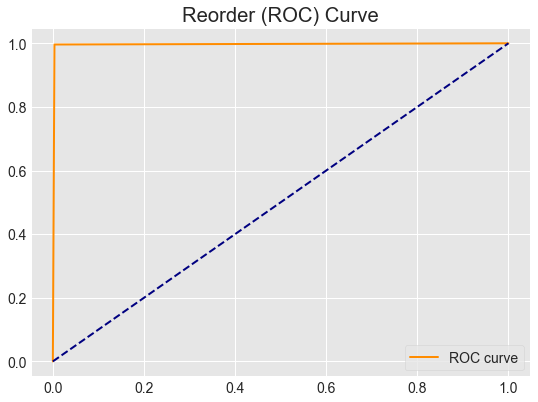

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gen_auc_viz(fpr, tpr, thresholds)

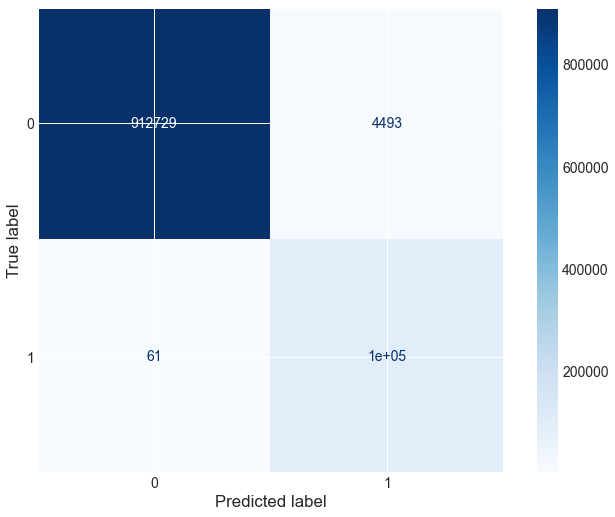

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    917222
           1       0.97      1.00      0.98     99738

    accuracy                           1.00   1016960
   macro avg       0.98      1.00      0.99   1016960
weighted avg       1.00      1.00      1.00   1016960

f1:0.98221,auc:0.99634,loss_score:0.00354


In [48]:
plot_cm(lr, X_test, y_test, y_pred)
f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

### Tuning right probability threshold 
Goal is to set probability threshold to different intervals, and see which threshold produces the 'best' success metric.

In [49]:

for i in np.arange(0.0,0.8,0.05):
    prob_thresh = i
    cm = pd.DataFrame(metrics.confusion_matrix
                      (y_true=y_test, y_pred=reorder_logit_prob > i), 
                      columns=['Negative Pred', 'Positive Pred'])
    tn = cm.iloc[0,0]
    fn = cm.iloc[1,0]
    fp = cm.iloc[0,1]
    tp = cm.iloc[1,1]
    
    acc = (tp+tn) / (tp+tn+fp+fn)
    sen = (tp) / (tp+fn) #summarizes how well the positive class was predicted.
    prec = tp / (tp+fp) #summarizes the fraction of examples assigned the positive class that belong to the positive class
    rec = tp/(tp+fn) #same as sensitivity 
    pp = tp / (tp+fp)

    f1=f1_score(y_test,reorder_logit_prob > i)
    brier=brier_score_loss(y_test, reorder_logit_prob > i)
    auc=roc_auc_score(y_test, reorder_logit_prob > i)

    print(round(i,2),f"accuracy:{acc:.5f},sensitivity:{sen:.5f},precision:{prec:.5f},recall:{rec:.5f}, ppv:{pp:5f}")
    print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")
    print(" ")

0.0 accuracy:0.10644,sensitivity:1.00000,precision:0.09890,recall:1.00000, ppv:0.098902
f1:0.18000,auc:0.50464,loss_score:0.89356
 
0.05 accuracy:0.99380,sensitivity:1.00000,precision:0.94053,recall:1.00000, ppv:0.940525
f1:0.96935,auc:0.99656,loss_score:0.00620
 
0.1 accuracy:0.99416,sensitivity:1.00000,precision:0.94378,recall:1.00000, ppv:0.943783
f1:0.97108,auc:0.99676,loss_score:0.00584
 
0.15 accuracy:0.99450,sensitivity:1.00000,precision:0.94688,recall:1.00000, ppv:0.946883
f1:0.97272,auc:0.99695,loss_score:0.00550
 
0.2 accuracy:0.99491,sensitivity:0.99996,precision:0.95073,recall:0.99996, ppv:0.950735
f1:0.97473,auc:0.99716,loss_score:0.00509
 
0.25 accuracy:0.99532,sensitivity:0.99987,precision:0.95456,recall:0.99987, ppv:0.954562
f1:0.97669,auc:0.99735,loss_score:0.00468
 
0.3 accuracy:0.99566,sensitivity:0.99968,precision:0.95794,recall:0.99968, ppv:0.957938
f1:0.97836,auc:0.99745,loss_score:0.00434
 
0.35 accuracy:0.99599,sensitivity:0.99934,precision:0.96133,recall:0.9993

A good threshold that optimizes on f1 + auc as well as loss. is .55

In [53]:
cm = pd.DataFrame(metrics.confusion_matrix
                  (y_true=y_test, y_pred=reorder_logit_prob > 0.55), 
                  columns=['Negative Pred', 'Positive Pred'])

scores_output(y_test, reorder_logit_prob > 0.55)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    917222
           1       0.97      0.99      0.98     99738

    accuracy                           1.00   1016960
   macro avg       0.99      1.00      0.99   1016960
weighted avg       1.00      1.00      1.00   1016960

f1:0.98238,auc:0.99550,loss_score:0.00350


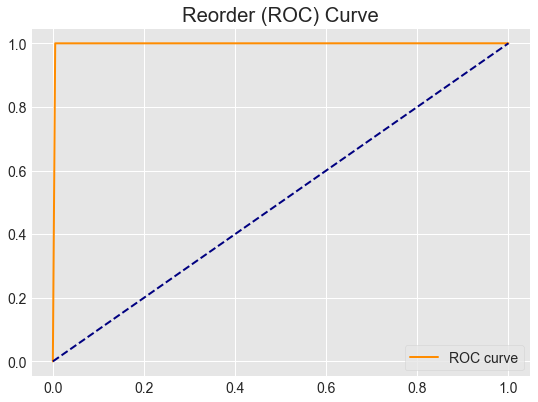

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, reorder_logit_prob > 0.25)
#Visualization for ROC curve
gen_auc_viz(fpr, tpr, thresholds)

## Feature Selection 

### Select K Best 

In [56]:
from sklearn.feature_selection import SelectKBest, chi2

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_model_new = SelectKBest(score_func=chi2,k=20)
fit= X_model_new.fit(X_train,y_train)
X_model_new
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  

In [57]:
feature_ranks = feature_scores.sort_values('Score', ascending=False).reset_index(drop=True)
feature_ranks.rename(columns={"Feature_Name":"Select_K_rank","Score":"Select_K_score"},inplace=True)
feature_ranks

,Select_K_rank,Select_K_score
0,product_ordered_vol,9500942049.611
1,order_id,4787664.293
2,user_product_last_time_product_ordered,4481474.935
3,user_lifetime_days,3810156.158
4,user_total_products,3770343.211
5,user_product_count,2230045.215
6,user_total_orders,646274.367
7,user_product_last_order,424381.878
8,user_product_first_order,411036.554
9,product_id,225094.014


In [60]:
best_features = feature_ranks['Select_K_rank'][:13]
best_features = best_features.tolist()

<AxesSubplot:>

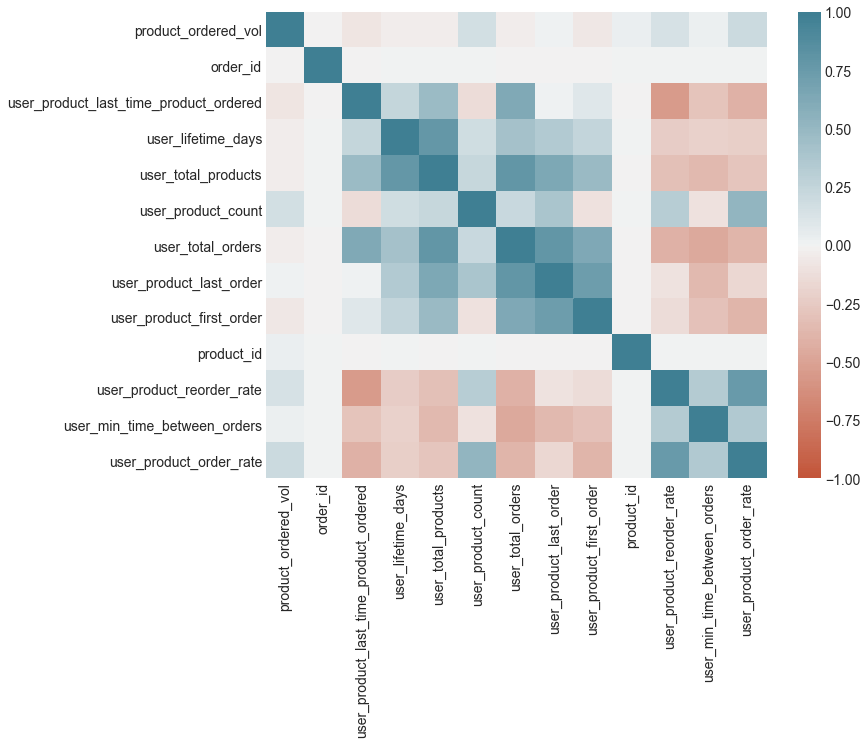

In [62]:
sns.heatmap(full_new[best_features].corr(),vmin=-1, vmax=1, center=0,
           cmap=sns.diverging_palette(20, 220, n=200))

In [63]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#New X and y with new features
X_new = X_train[best_features]

#Standard Scalar
# scaler = StandardScaler()
# Z_scaled = scaler.fit_transform(X)

#TTS
# X_train, X_test, y_train, y_test = train_test_split(
#     X,y, test_size=0.2, random_state=42)

#Fit model
logreg = LogisticRegression(penalty = 'l2', C= 0.01, max_iter=500)
logreg.fit(X_train, y_train)

#store outputs 
y_pred = logreg.predict(X_test)

#store probabilities 
reorder_logit_prob = logreg.predict_proba(X_test)[:,1]

#create confusion matrix and metrics 
cm = pd.DataFrame(metrics.confusion_matrix
                  (y_true=y_test, y_pred=reorder_logit_prob > 0.25), 
                  columns=['Negative Pred', 'Positive Pred'])
tn = cm.iloc[0,0]
fn = cm.iloc[1,0]
fp = cm.iloc[0,1]
tp = cm.iloc[1,1]

acc = (tp+tn) / (tp+tn+fp+fn)
sen = (tp) / (tp+fn)
prec = tp / (tp+fp)
rec = tp/(tp+fn)
pp = tp / (tp+fp)

f1=f1_score(y_test,reorder_logit_prob > .65)
brier=brier_score_loss(y_test, reorder_logit_prob > .65)
auc=roc_auc_score(y_test, reorder_logit_prob > .65)

print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

#plot ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

#Visualization for ROC curve
gen_auc_viz(fpr, tpr, thresholds)

### RFE

In [ ]:
# from sklearn.feature_selection import RFE

# selector = RFE(logreg, n_features_to_select = 1)
# selector = selector.fit(X_train, y_train);

# order = selector.ranking_
# order

In [ ]:
# feature_rank = []
# for i in order:
#     feature_ranks.append(f"{i} {full_new.columns[i]}") 

### Select from model

In [ ]:
# from sklearn.feature_selection import SelectFromModel
# sfm = SelectFromModel(logreg, threshold= -np.inf, max_features =20)
# sfm.fit(X_train, y_train)

# # select_scores = pd.DataFrame(smf.estimator_.coef_)
# # select_cols = pd.DataFrame(X_train.columns)

# # feature_scores = pd.concat([select_cols, select_scores],axis=1)
# # feature_scores.columns = ['select_from_model_cols','select_from_model_scores']

# # feature_scores

# feature_idx = sfm.get_support()
# feature_name = X_train.columns[feature_idx]
# feature_name


In [ ]:
# new_cols = feature_name
# X_new = df_removed[new_cols]
# y_new = df_removed['target']

# logreg = LogisticRegression(max_iter=500)
# logreg.fit(X_new, y_new)

# reorder_logit_prob_new = logreg.predict_proba(X_test)[:,1]
# reorder_thresh = reorder_logit_prob_new > 0.4

# cm = pd.DataFrame(metrics.confusion_matrix
#                   (y_true=y_new, y_pred=reorder_thresh), 
#                   columns=['Negative Pred', 'Positive Pred'])
# tn = cm.iloc[0,0]
# fn = cm.iloc[1,0]
# fp = cm.iloc[0,1]
# tp = cm.iloc[1,1]

# acc = (tp+tn) / (tp+tn+fp+fn)
# sen = (tp) / (tp+fn)
# prec = tp / (tp+fp)
# rec = tp/(tp+fn)
# pp = tp / (tp+fp)

# f1=f1_score(y_test,reorder_thresh)
# brier=brier_score_loss(y_test, reorder_thresh)
# auc=roc_auc_score(y_test, reorder_thresh)

# print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

## Validate
Run model against validation set

In [73]:
X_val= validate[best_features]
y_val= validate['target']

(X_val-train_mean)/train_std
# X_val.dropna()
# X_val

,order_id,product_id,product_order_twice_ratio,product_ordered_vol,user_avg_cart_size,user_avg_days_between_orders,user_id,user_lifetime_days,user_max_time_between_orders,user_min_time_between_orders,user_product_avg_basket_placement,user_product_count,user_product_first_order,user_product_last_order,user_product_last_time_product_ordered,user_product_order_rate,user_product_reorder_rate,user_total_orders,user_total_products,user_unique_product_perc
6741211,0.974,1.344,nan,-0.208,nan,nan,nan,-1.018,nan,-0.349,nan,-0.422,-0.572,-0.758,-0.382,-0.139,-0.358,-0.825,-0.763,nan
7855177,0.447,-0.463,nan,-0.383,nan,nan,nan,-0.672,nan,-0.349,nan,-0.422,0.914,0.391,-0.308,-0.709,-0.468,0.119,-0.615,nan
4043056,1.054,-1.231,nan,-0.332,nan,nan,nan,-0.191,nan,-0.349,nan,-0.422,0.171,-0.184,1.171,-0.764,-0.954,0.568,-0.151,nan
3473452,-0.127,-0.229,nan,-0.318,nan,nan,nan,-0.401,nan,0.040,nan,-0.147,-0.720,-0.413,-0.603,0.219,-0.289,-0.690,-0.480,nan
4073908,-1.691,1.426,nan,-0.334,nan,nan,nan,-0.601,nan,0.820,nan,-0.422,-0.274,-0.528,-0.603,-0.226,0.407,-0.780,-0.657,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784146,-0.942,-1.486,nan,-0.258,nan,nan,nan,0.300,nan,-0.739,nan,-0.422,1.806,1.080,-0.234,-0.776,-0.550,0.703,0.319,nan
5428073,1.379,1.491,nan,-0.175,nan,nan,nan,-1.110,nan,-0.739,nan,-0.147,-0.720,-0.471,-0.382,0.043,-0.417,-0.600,-0.644,nan
2584217,-0.615,1.371,nan,1.466,nan,nan,nan,1.787,nan,0.235,nan,2.055,-0.274,0.850,-0.677,1.041,0.642,0.254,0.948,nan
6607998,0.184,-1.466,nan,-0.225,nan,nan,nan,-0.118,nan,-0.155,nan,-0.422,-0.720,-0.873,0.210,-0.476,-0.796,-0.555,0.023,nan


f1:0.9822731081811467,auc:0.9949682536522946


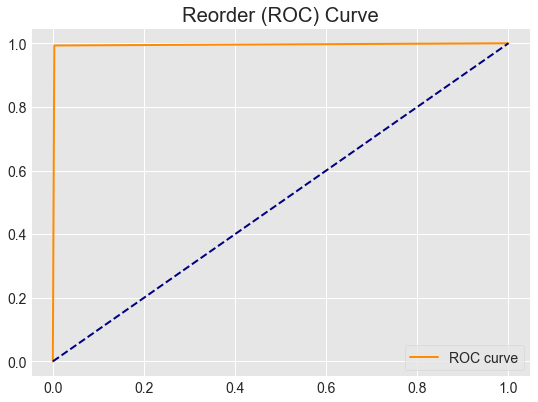

In [87]:
#Final model 
logreg = LogisticRegression(penalty = 'l2', C= 1000, max_iter=500)
logreg.fit(X_train, y_train)

reorder_logit_prob = logreg.predict_proba(X_test)[:,1]

f1=f1_score(y_test,reorder_logit_prob > .55)
brier=brier_score_loss(y_test, reorder_logit_prob > .55)
auc=roc_auc_score(y_test, reorder_logit_prob > .55)

print(f"f1:{f1},auc:{auc}")

#plot ROC 
fpr, tpr, thresholds = roc_curve(y_test, reorder_logit_prob > .55)

#Visualization for ROC curve
gen_auc_viz(fpr, tpr, thresholds)

In [91]:
X_val = validate.drop(["target",'eval_set'],axis=1)
y_val = validate['target']

#New X and y for validation data
X_val= validate[best_features]

#Standardize using training mean/std 
X_val = (X_val-train_mean)/train_std
X_val.dropna(axis=1,inplace=True)

X_val

# logreg = LogisticRegression(penalty = 'l2', C= 1000, max_iter=500)
# logreg.fit(X_val, y_val)

reorder_logit_prob = logreg.predict_proba(X_val)[:,1]

# f1=f1_score(y_val,reorder_logit_prob > .55)
# brier=brier_score_loss(y_val, reorder_logit_prob > .55)
# auc=roc_auc_score(y_val, reorder_logit_prob > .55)

# print(f"f1:{f1},auc:{auc}")

# #plot ROC 
# fpr, tpr, thresholds = roc_curve(y_val, reorder_logit_prob > .55)

# #Visualization for ROC curve
# gen_auc_viz(fpr, tpr, thresholds)

,order_id,product_id,product_ordered_vol,user_lifetime_days,user_min_time_between_orders,user_product_count,user_product_first_order,user_product_last_order,user_product_last_time_product_ordered,user_product_order_rate,user_product_reorder_rate,user_total_orders,user_total_products
6741211,0.974,1.344,-0.208,-1.018,-0.349,-0.422,-0.572,-0.758,-0.382,-0.139,-0.358,-0.825,-0.763
7855177,0.447,-0.463,-0.383,-0.672,-0.349,-0.422,0.914,0.391,-0.308,-0.709,-0.468,0.119,-0.615
4043056,1.054,-1.231,-0.332,-0.191,-0.349,-0.422,0.171,-0.184,1.171,-0.764,-0.954,0.568,-0.151
3473452,-0.127,-0.229,-0.318,-0.401,0.040,-0.147,-0.720,-0.413,-0.603,0.219,-0.289,-0.690,-0.480
4073908,-1.691,1.426,-0.334,-0.601,0.820,-0.422,-0.274,-0.528,-0.603,-0.226,0.407,-0.780,-0.657
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784146,-0.942,-1.486,-0.258,0.300,-0.739,-0.422,1.806,1.080,-0.234,-0.776,-0.550,0.703,0.319
5428073,1.379,1.491,-0.175,-1.110,-0.739,-0.147,-0.720,-0.471,-0.382,0.043,-0.417,-0.600,-0.644
2584217,-0.615,1.371,1.466,1.787,0.235,2.055,-0.274,0.850,-0.677,1.041,0.642,0.254,0.948
6607998,0.184,-1.466,-0.225,-0.118,-0.155,-0.422,-0.720,-0.873,0.210,-0.476,-0.796,-0.555,0.023


In [85]:
#New X and y for validation data
X_te= test[best_features]
y_te= test['target']

#Standardize using training mean/std 
X_te = (X_te-train_mean)/train_std
X_te.dropna(axis=1,inplace=True)

X_te

logreg = LogisticRegression(penalty = 'l2', C= 1000, max_iter=500)
logreg.fit(X_te, y_te)

reorder_logit_prob = logreg.predict_proba(X_te)[:,1]

f1=f1_score(y_val,reorder_logit_prob > .55)
brier=brier_score_loss(y_val, reorder_logit_prob > .55)
auc=roc_auc_score(y_val, reorder_logit_prob > .55)

print(f"f1:{f1},auc:{auc}")

#plot ROC 
fpr, tpr, thresholds = roc_curve(y_val, reorder_logit_prob > .55)

#Visualization for ROC curve
gen_auc_viz(fpr, tpr, thresholds)

,order_id,product_id,product_ordered_vol,user_lifetime_days,user_min_time_between_orders,user_product_count,user_product_first_order,user_product_last_order,user_product_last_time_product_ordered,user_product_order_rate,user_product_reorder_rate,user_total_orders,user_total_products
3494955,-1.625,-0.613,2.151,-0.775,-0.349,0.128,-0.646,-0.643,-0.234,0.648,0.129,-0.645,-0.812
1809206,-0.100,-0.610,-0.370,0.263,-0.544,-0.422,1.211,0.620,-0.308,-0.735,-0.468,0.299,0.020
1344580,-1.703,-1.790,-0.382,-0.517,1.989,-0.147,-0.646,-0.643,-0.677,1.172,0.713,-0.915,-0.766
4135569,0.790,-0.684,-0.359,0.002,-0.349,-0.422,-0.572,-0.758,1.023,-0.693,-0.940,0.029,-0.264
6724866,-0.144,1.371,-0.317,0.848,-0.349,-0.422,0.171,-0.184,1.541,-0.783,-0.980,0.793,1.351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7204212,0.445,-0.466,-0.328,-0.950,1.015,-0.422,-0.572,-0.758,-0.603,0.333,0.407,-0.960,-0.895
2234489,-0.485,-0.291,-0.120,-0.655,0.430,-0.147,-0.572,-0.586,-0.382,0.219,-0.103,-0.690,-0.757
4304572,0.906,-0.968,-0.401,-0.422,2.184,-0.147,-0.646,-0.643,-0.529,0.648,0.188,-0.825,-0.776
6550634,0.484,-0.613,2.151,-0.053,-0.739,-0.422,-0.646,-0.815,5.016,-0.847,-1.065,2.411,1.141
